# Importing the necessary libraries

In [1]:
#Import libraries
%matplotlib inline
import os
import pandas as pd

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import tensorflow as tf
import glob
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.misc import imresize
import keras
import seaborn as sns

Using TensorFlow backend.


In [2]:
textureimages = np.load('textureimagequality20.npy')

In [3]:
#Load images
folder=os.getcwd()+'/photos/'+'texture/'

filelist = glob.glob(folder+'/*.png')
texturefiles = np.array([np.array(fname.split('/')[-1].replace('.png','')) for fname in filelist])
texturefiles = list(map(int, texturefiles))

In [13]:
texture = pd.read_csv('texture.csv')
texture = texture.drop(['Unnamed: 0'],axis=1)
texture['texture'] = texture.texture.str.replace(',','.')
texture['texture'] = pd.to_numeric(texture['texture'])
texture['inx']   = texture.index

texturefiles = pd.DataFrame(texturefiles,columns=['inx'])
texturedata = texturefiles.merge(texture,on='inx')

errorimages = [1126,1132,1143]
errorindex  = texturedata[texturedata.inx.isin(errorimages)].index.values
texturedata = texturedata.drop(errorindex)
texturedata = texturedata.drop(['filename','empresa','gravel_size','image'],axis=1)
#texturedata = texturedata.drop(['filename','empresa','gravel_size','image','inx'],axis=1)
texturedata['category'] = pd.cut(texturedata.texture,bins=[-0.01,165,275,350,460,20000],labels=[0, 1, 2, 3, 4])

In [15]:
texturedata.iloc[1217]

inx            52
texture     578.5
category        4
Name: 1220, dtype: object

In [5]:
texturedata.to_csv("texturedataprepared.csv")

In [10]:
x_train = textureimages[:].astype('float32')/255
y_train = texturedata['texture'][:]

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=1)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=1)

train_size, length, height, channels = x_train.shape

In [11]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()
model.add(Conv2D(filters=int(length/2), kernel_size=2, padding='same', activation='relu', 
                        input_shape=(length, height,channels)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=length, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=length*2, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dense(1000, activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 128, 48)       816       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 64, 48)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 64, 96)        18528     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 32, 96)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 32, 192)       73920     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 16, 192)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 16, 192)       0         
__________

In [12]:
from keras.callbacks import ModelCheckpoint
from keras import backend
def rsquared(y_true, y_pred):
    residuals     =  backend.sum(backend.square(y_true - y_pred)) 
    mean_residual = backend.sum(backend.square(y_true - backend.mean(y_true))) 
    return (1 - residuals/(mean_residual))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam', 
                  metrics=[rsquared])

checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, 
                               save_best_only=True)



In [13]:
hist = model.fit(x_train, y_train, batch_size=30, epochs=20,
          validation_data=(x_valid, y_valid), callbacks=[checkpointer], 
          verbose=2, shuffle=True)

Train on 909 samples, validate on 228 samples
Epoch 1/20
Epoch 00000: val_loss improved from inf to 72300.45030, saving model to model.weights.best.hdf5
30s - loss: 135334.9713 - rsquared: -5.8677e-01 - val_loss: 72300.4503 - val_rsquared: 0.0285
Epoch 2/20
Epoch 00001: val_loss did not improve
29s - loss: 81600.4448 - rsquared: 0.0645 - val_loss: 73608.0923 - val_rsquared: -7.9942e-02
Epoch 3/20
Epoch 00002: val_loss improved from 72300.45030 to 56284.90625, saving model to model.weights.best.hdf5
31s - loss: 74566.6994 - rsquared: 0.1350 - val_loss: 56284.9062 - val_rsquared: 0.2222
Epoch 4/20
Epoch 00003: val_loss improved from 56284.90625 to 33112.44814, saving model to model.weights.best.hdf5
31s - loss: 53264.6185 - rsquared: 0.3831 - val_loss: 33112.4481 - val_rsquared: 0.4525
Epoch 5/20
Epoch 00004: val_loss improved from 33112.44814 to 17403.43090, saving model to model.weights.best.hdf5
38s - loss: 28311.9043 - rsquared: 0.6646 - val_loss: 17403.4309 - val_rsquared: 0.6829
Ep

In [14]:
# load the weights that yielded the best validation accuracy
model.load_weights('model.weights.best.hdf5')

In [15]:
# evaluate and print test accuracy
score = model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.987557741424


In [16]:
from sklearn.metrics import r2_score

y_hat = model.predict(x_test)

r2_score(y_test,y_hat)

0.98832604954766201

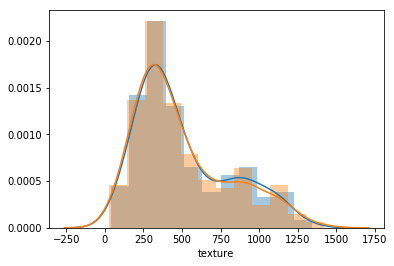

In [17]:
sns.distplot(y_hat)
sns.distplot(y_test)

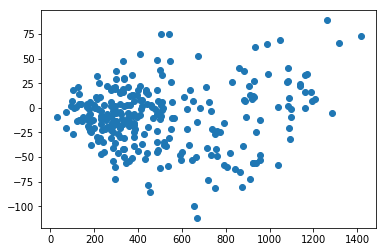

In [18]:
y_test = y_test.values.reshape((y_test.shape[0],1))
residual = y_test - y_hat
plt.plot(y_test,residual,'o')

In [19]:
np.mean((residual**2)**0.5)

24.762347944828505

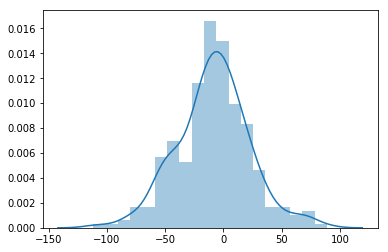

In [20]:
sns.distplot(residual)

In [103]:
# Categorical classification
df = pd.DataFrame(y_test)
category_test = pd.cut(df[0],bins=[-0.01,200,500,750,20000],labels=[0, 1, 2, 3])
df = pd.DataFrame(y_hat)
category_pred = pd.cut(df[0],bins=[-0.01,200,500,750,20000],labels=[0, 1, 2, 3])
category_test = category_test.values.astype(dtype='int')
category_pred = category_pred.values.astype(dtype='int')
accuracy      = 1 - np.sum(((category_pred - category_test)**2)**0.5)/len(category_pred) #penalized by
                                                                                         #distance of classification